# Лабораторная работа 6

## Семантическая сегментация
## Выполнил Лисин Роман, М8О-406Б-20



In [1]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from google.colab import userdata

In [2]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [3]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [4]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [5]:
train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)


100%|██████████| 1999639040/1999639040 [00:23<00:00, 83660361.25it/s]


Extracting ./VOCtrainval_11-May-2012.tar to .


In [ ]:
train_dataset[0][1].shape

torch.Size([21, 256, 256])

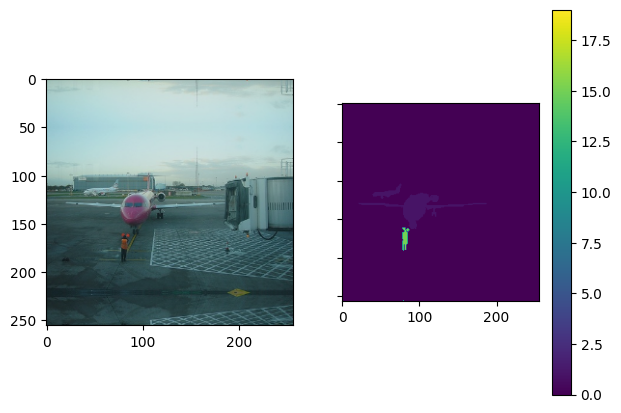

In [ ]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [6]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [7]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 50.0MB/s]


In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)

In [ ]:
dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)

In [ ]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [ ]:
model = model.cuda()

In [ ]:
r_losses = []
rloss = 0
next_desc = "first epoch"
for epoch in range(5):

  for img,lbl in tqdm(dataloader, desc = next_desc):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    loss = crit(predict, lbl)
    loss.backward()
    optim.step()
    optim.zero_grad()
    rloss += loss.detach().cpu().item() / len(dataloader)
  r_losses+= [rloss]
  next_desc = f"Epoch: [{epoch+1}], previous rloss: [{rloss:.3f}]"
  rloss = 0

Epoch: [4], previous rloss: [0.323]:  50%|█████     | 92/183 [02:13<02:11,  1.44s/it]

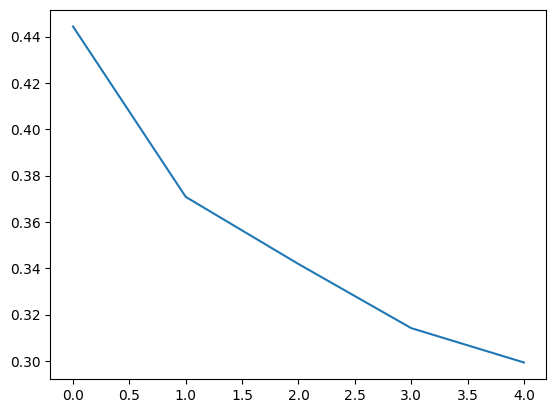

In [ ]:
plt.plot(r_losses)


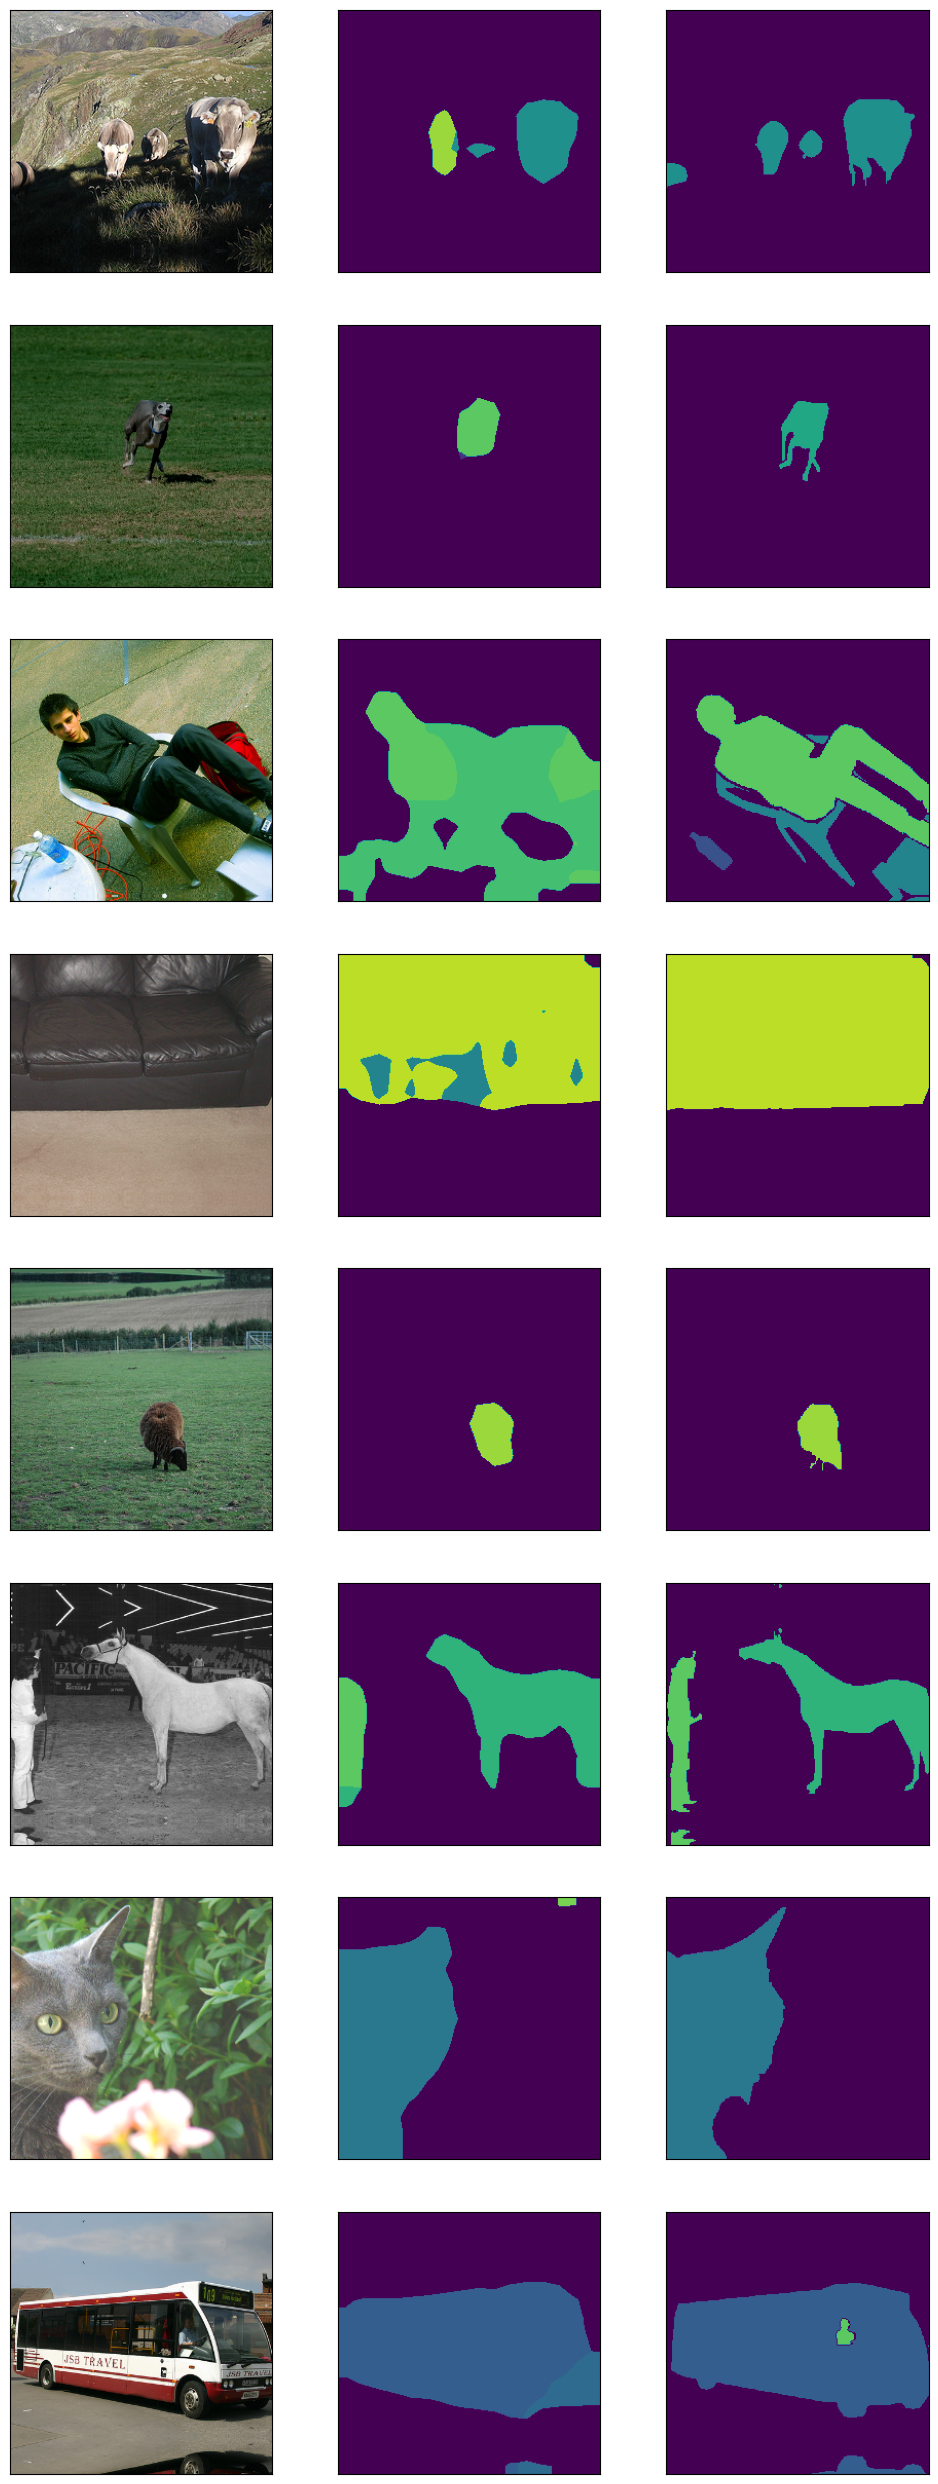

In [ ]:
fig,axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu().softmax(1), lbl.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()

#### Задание
0. Гиперпараметры (модель, оптимизатор и его параметры, шедулер и имя функции ошибки) для экспериментов конфигурировать через класс-контейнер (может быть `namedtuple`,`dataclass`, `pydantic.Model` или просто класс без методов (кроме __init__).
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в clearml табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив. Таблицы, графики и т.д. Можно забрать из clearml).
** При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять.



### Гиперпараметры

In [9]:
from dataclasses import dataclass

@dataclass
class Hyperparams:
    model: str
    optimizer: str
    lr: float
    scheduler: str
    loss_fn: str
    label_smoothing: float

hyperparams = Hyperparams(
    model="deeplabv3_mobilenet_v3_large",
    optimizer="AdamW",
    lr=3e-5,
    scheduler="ReduceLROnPlateau",
    loss_fn="CrossEntropyLoss",
    label_smoothing=1e-5
)

### Расчет метрик IoU и MIoU

In [22]:
from torch.nn import functional as F

def iou(match_pred, match_gt):
    eps = 1e-10
    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
    union = torch.logical_or(match_pred, match_gt).sum().float().item()
    iou = (intersect + eps) / (union + eps)
    return iou


def iou_per_class(pred, gt, n_cls=len(VOC_CLASSES)):
    pred = torch.argmax(F.softmax(pred, dim=1), dim=1).contiguous().view(-1)
    gt = torch.argmax(gt, dim=1).contiguous().view(-1)
    iou_class = []
    for c in range(n_cls):
        match_pred = pred == c
        match_gt = gt == c
        iou_class.append(iou(match_pred, match_gt))
    return iou_class


def miou(iou_class):
    return np.nanmean(iou_class)

### Обучение с валидацией и подсчётом требуемых метрик

In [11]:
!pip install clearml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [15]:
import clearml
clearml.browser_login()

<IPython.core.display.Javascript object>

ClearML automatic browser login failed, please login or create a new account
To get started with ClearML: setup your own `clearml-server`, or create a free account at https://app.clear.ml

Please login to https://app.clear.ml , then press [Enter] to connect r.lisin@group-ib.com


<IPython.core.display.Javascript object>


We cannot connect automatically (adblocker / incognito?) 😟 
Please go to https://app.clear.ml/settings/workspace-configuration 
Then press  + Create new credentials  
And copy/paste your Access Key here: BQBUDXNI502DHFUZSTET
 Setting access key 
Now copy/paste your Secret Key here: z5CgWQne1lvUOrQVNxNcuiGVPZ0kCRjupqU8UNjpCYMwjeszBP
 Setting secret key 


Hurrah! 🥳 🎊 🎉
🤖 ClearML connected successfully - let's build something! 🚀


In [24]:
from clearml import Task, Logger


def train(hyperparams: Hyperparams, train_dataset, val_dataset):
    batch_size = 8
    epochs = 5
    model = getattr(torchvision.models.segmentation, hyperparams.model)(True, num_classes=len(VOC_CLASSES), progress=True)
    optimizer = getattr(torch.optim, hyperparams.optimizer)(model.parameters(), lr=hyperparams.lr)
    scheduler = getattr(torch.optim.lr_scheduler, hyperparams.scheduler)(optimizer)
    loss_fn = getattr(torch.nn, hyperparams.loss_fn)()
    model = model.cuda()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):

        train_loss = 0.0
        for images, labels in train_dataloader:
            outputs = model(images.cuda())["out"]
            loss = loss_fn(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            cur_loss = loss.item()
            train_loss += cur_loss
            Logger.current_logger().report_scalar(
                "train", "loss", iteration=epoch, value=cur_loss)

        val_loss, val_miou = validate(model, valid_dataloader, loss_fn, last_val=(epoch==epochs-1))

        Logger.current_logger().report_scalar(
                "val", "loss", iteration=epoch, value=val_loss)
        Logger.current_logger().report_scalar(
                "val", "miou", iteration=epoch, value=val_miou)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train loss: {train_loss/len(train_dataloader)}, Val loss: {val_loss}, Val MIoU: {val_miou}")


def validate(model, dataloader, loss_fn, last_val):
    global all_ious
    model.eval()
    with torch.no_grad():
        losses = []
        mious = []
        ious = []
        for images, labels in dataloader:
            outputs = model(images.cuda())["out"]
            loss = loss_fn(outputs, labels.cuda())

            losses.append(loss.item())
            ious = iou_per_class(outputs, labels.cuda())
            if last_val:
                all_ious.append(ious)
            mious.append(miou(ious))
    model.train()
    if last_val:
        print(f"IoU в среднем по датасету в развертке по классам: {np.mean(np.array(all_ious), axis=0)}")
    return sum(losses) / len(dataloader), sum(mious) / len(dataloader)

In [25]:
train_dataset = PascalVOCSearchDataset('.',download = True, image_set="train", transform = augs)
val_dataset = PascalVOCSearchDataset('.',download = True, image_set="val", transform = augs)

task = Task.init(project_name='Semantic segmentation', task_name='PascalVOCSearchDataset')

all_ious = []
train(hyperparams, train_dataset, val_dataset)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Epoch 1/5, Train loss: 0.4498680965985105, Val loss: 0.3268442762667661, Val MIoU: 0.7106809405744559
Epoch 2/5, Train loss: 0.38748324011030094, Val loss: 0.29536138818814206, Val MIoU: 0.7207779825825483
Epoch 3/5, Train loss: 0.34241731725429575, Val loss: 0.2840597218946441, Val MIoU: 0.7135020235767938
Epoch 4/5, Train loss: 0.31846596532669225, Val loss: 0.3091555426900203, Val MIoU: 0.7247082768362785
IoU в среднем по датасету в развертке по классам: [0.84935117 0.81910044 0.68354508 0.80071197 0.7513905  0.66416808
 0.82371126 0.71526316 0.72848449 0.49221716 0.80569262 0.62473731
 0.7073251  0.78265751 0.77073746 0.63604116 0.67900887 0.8114953
 0.57376942 0.79193728 0.72350809]
Epoch 5/5, Train loss: 0.30184565048888734, Val loss: 0.27051573525090794, Val 

### Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%

In [31]:
def show_images(images, labels, n_images=3):
    for i in range(n_images):
        fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
        axs = axs.ravel()
        axs[0].imshow(images[i].permute(1, 2, 0))
        axs[0].set_title("Image")
        axs[1].imshow(labels[i].argmax(0), vmax = len(VOC_CLASSES)-1)
        axs[1].set_title("Label")
        plt.show()

In [53]:
def select_images(val_dataset, ious, quantiles=((0, 0.1), (0.15, 0.25), (0.45, 0.55)), limit=2):
    mean_ious = np.mean(np.array(ious), axis=1)
    sorted_ious = sorted(list(enumerate(mean_ious)), key=lambda x: x[1])
    for quantile in quantiles:
        images_selected = []
        labels_selected = []
        down, up = np.quantile(mean_ious, quantile)
        for batch_idx, el in sorted_ious:
            if down <= el <= up:
                for i in range(limit):
                    img, lbl = val_dataset[batch_idx * 8 + i]
                    images_selected.append(img)
                    labels_selected.append(lbl)
                break
        print(f"Квантиль {quantile}")
        show_images(images_selected, labels_selected, n_images=limit)

Квантиль (0, 0.1)


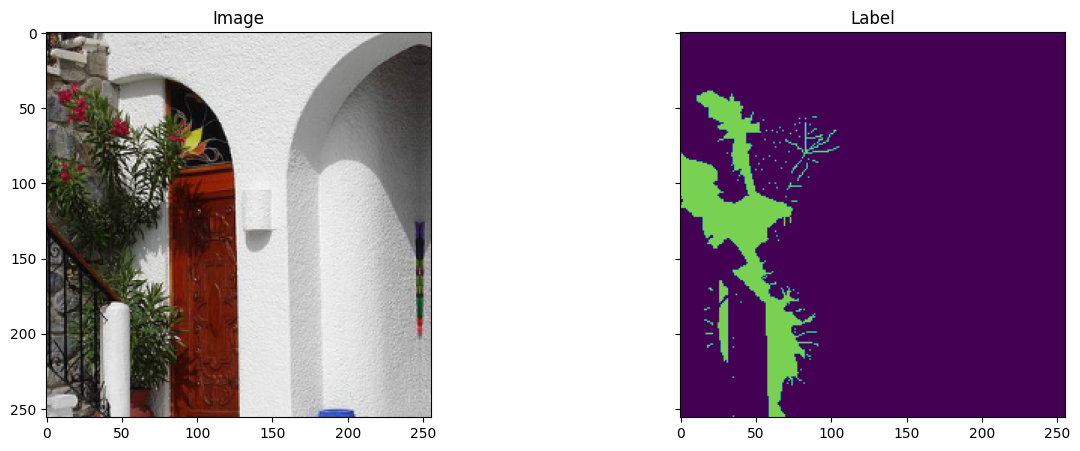

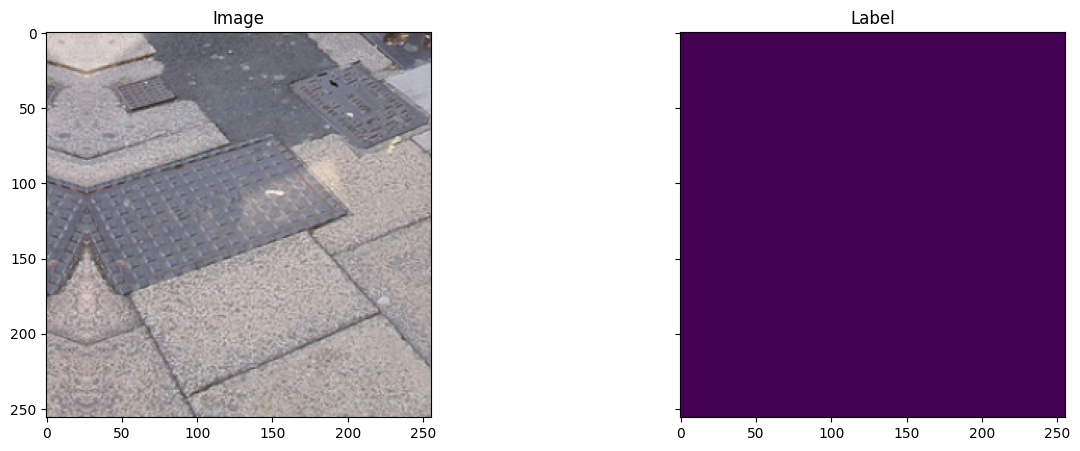

Квантиль (0.15, 0.25)


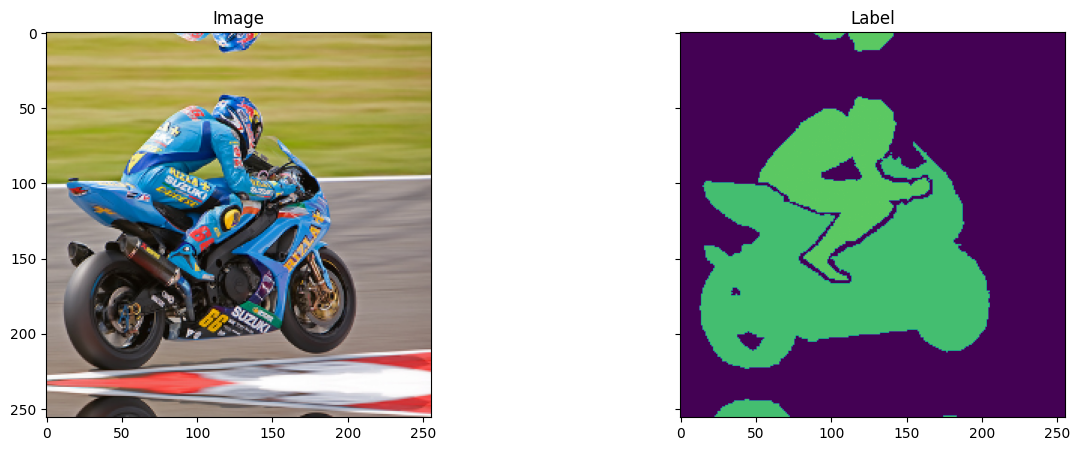

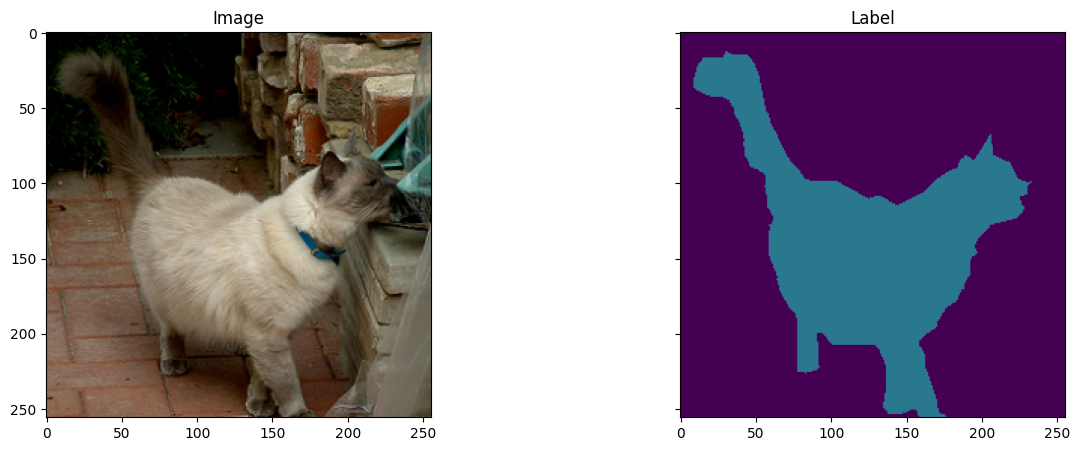

Квантиль (0.45, 0.55)


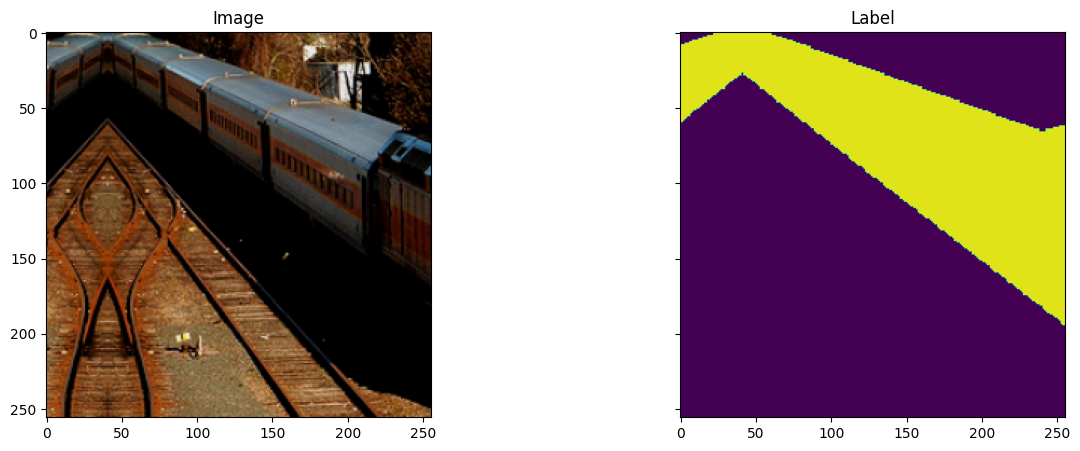

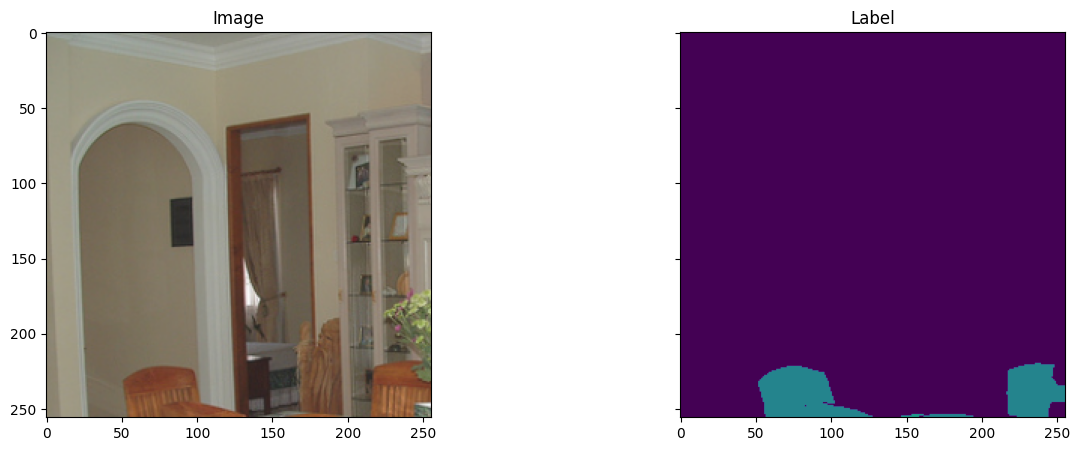

In [54]:
select_images(val_dataset, all_ious)

### Отобрать лучшую по качеству IoU картинку по трем выбранным классам

In [75]:
def select_best_image_for_class(val_dataset, ious, cls_n):
    return val_dataset[np.argmax(np.array(ious), axis=0)[cls_n] * 8]

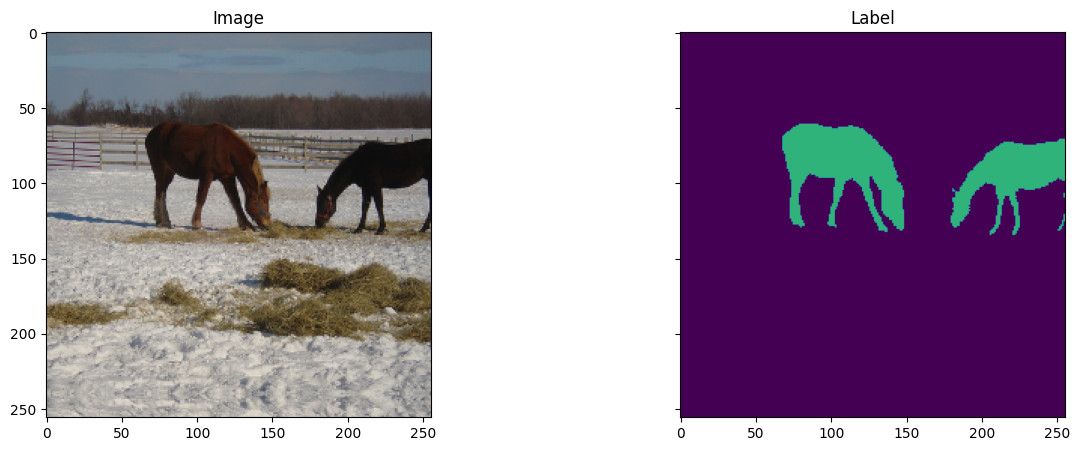

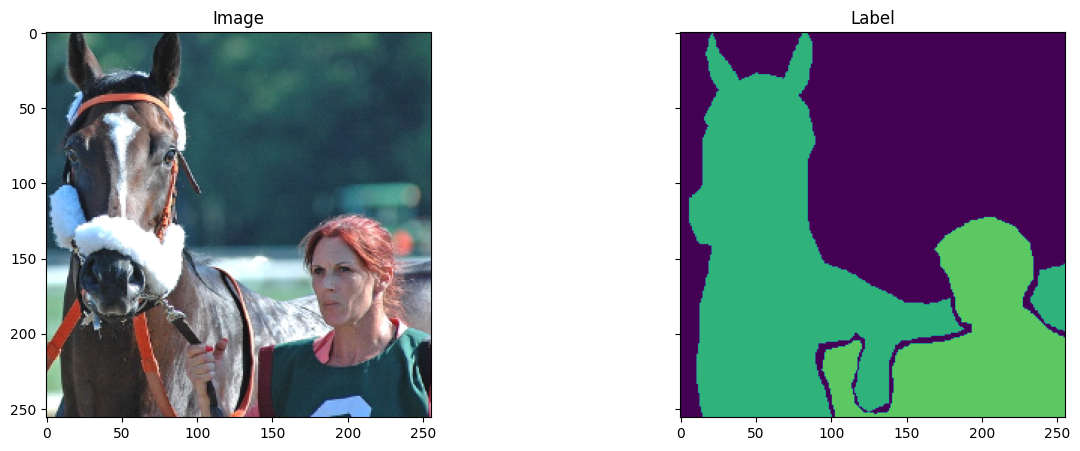

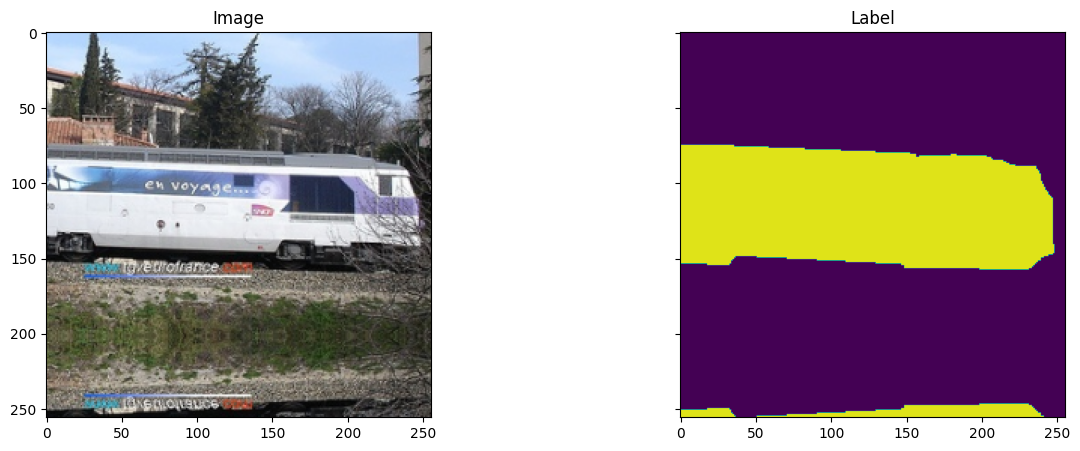

In [76]:
class1 = 0
class2 = 1
class3 = 2
images = []
labels = []

for c in (class1, class2, class3):
    img, lbl = select_best_image_for_class(val_dataset, all_ious, c)
    images.append(img)
    labels.append(lbl)
show_images(images, labels, n_images=3)

### Таблица IoU в развертке по каждому классу для лучшей модели

In [78]:
import pandas as pd
print("Таблица IoU в развертке по каждому классу для лучшей модели")
print(pd.DataFrame(all_ious))

Таблица IoU в развертке по каждому классу для лучшей модели
           0             1         2             3             4   \
0    0.764251  6.938444e-01  0.439704  1.000000e+00  2.104719e-01   
1    0.868372  6.591958e-14  0.199025  1.000000e+00  3.365870e-14   
2    0.789096  1.394700e-14  1.000000  1.000000e+00  1.000000e+00   
3    0.930936  1.000000e+00  1.000000  1.000000e+00  4.923996e-01   
4    0.896085  6.514276e-01  0.426303  5.968116e-01  1.000000e+00   
..        ...           ...       ...           ...           ...   
177  0.852749  6.354803e-01  0.327272  1.000000e+00  9.473187e-02   
178  0.879293  7.451857e-01  1.000000  1.876173e-13  5.646775e-01   
179  0.808292  1.000000e+00  0.467658  9.796020e-01  1.000000e+00   
180  0.729470  1.000000e+00  1.000000  4.779623e-01  1.000000e+00   
181  0.925339  1.000000e+00  1.000000  1.000000e+00  1.000000e+00   

               5         6         7             8             9   ...  \
0    1.000000e+00  1.000000  1.000000